In [1]:
using StaticArrays
using BenchmarkTools
using LinearAlgebra
using CUDA
using Adapt
#using Cthulhu
using StatsPlots
using BenchmarkPlots
using Profile
using Unitful
using UnitfulRecipes
using QuadGK
using Interpolations
using Distributions
include("src/photon_prob_cuda.jl")
include("src/medium.jl")
include("src/spectrum.jl")
using .Medium
using .Spectral
using .PhotonPropagation

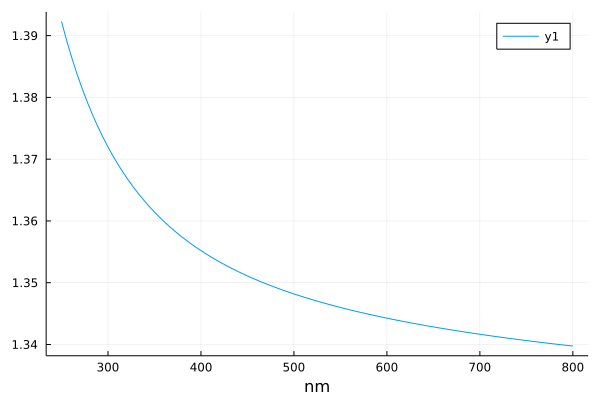

In [2]:
CascadiaMediumProperties = make_cascadia_medium_properties(Float32)
wls = range(250u"nm", 800u"nm", 100) 
plot(wls, get_refractive_index.(wls, Ref(CascadiaMediumProperties)))

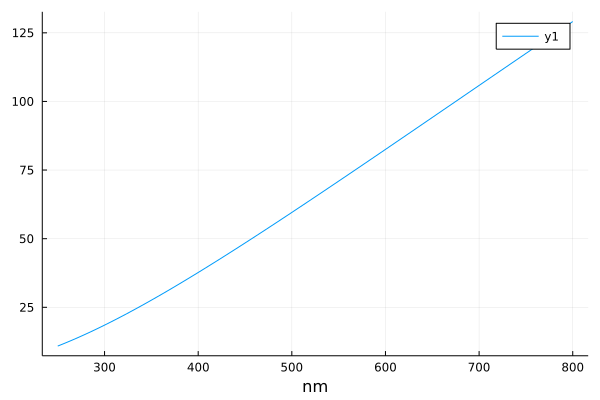

In [3]:
wls = range(250u"nm", 800u"nm", 100) 
plot(wls, get_scattering_length.(wls, Ref(CascadiaMediumProperties)))

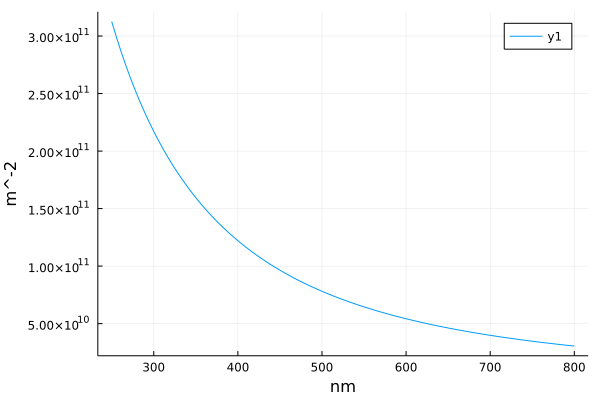

In [4]:
wls = range(250u"nm", 800u"nm", 100)
plot(wls, upreferred.(frank_tamm.(wls, Ref(1.32))))

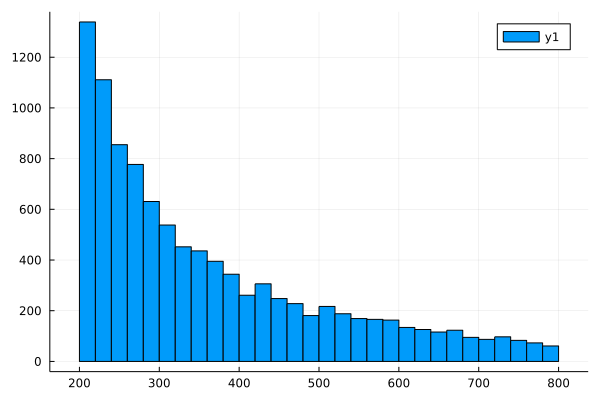

In [6]:
wl_range = (200f0, 800f0)
ck = Cherenkov(wl_range, 20, CascadiaMediumProperties)

unis = rand(Float32, 10000)

histogram(PhotonPropagation.cuda_fast_linear_interp.(unis, Ref(ck.knots), Ref(0f0), Ref(1f0)))


In [7]:
source = PhotonSource(@SVector[0f0, 0f0, 0f0], 0f0, Int64(10^5), Cherenkov((300f0, 800f0), 20, CascadiaMediumProperties), Isotropic{Float32}(), )
target = PhotonTarget(@SVector[0f0, 0f0, 100f0], 0.21f0)

threads = 1024
blocks = 16

stack_len = Int32(cld(1E5, blocks))

positions, directions, wavelengths, dist_travelled, stack_idx, n_ph_sim = initialize_photon_arrays(stack_len, blocks, Float32)

@cuda threads=threads blocks=blocks shmem=sizeof(Int32) cuda_propagate_photons!(
    positions, directions, wavelengths, dist_travelled, stack_idx, n_ph_sim, stack_len, Int32(0),
    Val(source), Val(target), Val(CascadiaMediumProperties))

MethodError: MethodError: no method matching PhotonSource(::SVector{3, Float32}, ::Float32, ::Int64, ::Cherenkov{Float32, 20}, ::Isotropic{Float32})
Closest candidates are:
  PhotonSource(::SVector{3, T}, ::T, ::Int64, !Matched::U, ::V) where {T, U<:Main.PhotonPropagation.Spectral.Spectrum, V<:Main.PhotonPropagation.EmissionProfile} at ~/repos/julia/PhotonProp.jl/src/photon_prob_cuda.jl:142

In [7]:
function process_output(output::AbstractVector{T}, stack_pointers::AbstractVector{U}) where {T<:Real, U<:Integer}
    out_size = size(output, 1)
    stack_len = Int64(out_size / size(stack_pointers, 1))

    stack_starts = collect(1:stack_len:out_size)
    out_sum = sum(stack_pointers .% stack_len)
    coalesced = Vector{T}(undef, out_sum)
    ix = 1
    for i in 1:size(stack_pointers, 1)
        sp = stack_pointers[i]
        this_len = (sp - stack_starts[i]) + 1
        coalesced[ix:ix+this_len-1] = output[stack_starts[i]:sp]
        #println("$(stack_starts[i]:sp) to $(ix:ix+this_len-1)")
        ix += this_len
       
    end
    coalesced
end

distt = process_output(Vector(dist_travelled), Vector(stack_idx))
surv_frac = size(distt, 1) / source.photons

0.0

In [6]:
1E8 * 0.004

400000.0

In [12]:
function make_bench_cuda_prop_photons(nph, blocks::Int32)
    
    source = PhotonSource(@SVector[0f0, 0f0, 0f0], 0f0, nph, Monochromatic(450f0), Isotropic{Float32}(), )
    target = PhotonTarget(@SVector[0f0, 0f0, 100f0], 0.21f0)

    threads = 1024
    # blocks = 16

    stack_len = max(Int32(4096), Int32(cld(nph*0.01, blocks)))

    positions, directions, wavelengths, dist_travelled, stack_idx, n_ph_sim = initialize_photon_arrays(stack_len, blocks, Float32)

    @cuda threads=threads blocks=blocks shmem=sizeof(Int32) cuda_propagate_photons!(
        positions, directions, wavelengths, dist_travelled, stack_idx, n_ph_sim, stack_len, Int32(0), Val(source), Val(target))

    bench = @benchmarkable @CUDA.sync @cuda threads=$threads blocks=$blocks shmem=sizeof(Int32) $cuda_propagate_photons!(
        $positions, $directions, $wavelengths, $dist_travelled, $stack_idx, $n_ph_sim, $stack_len, Int32(0), Val($source), Val($target))

    
    bench
end

#output

make_bench_cuda_prop_photons (generic function with 1 method)

In [13]:
suite = BenchmarkGroup()

nphs = trunc.(Int, 10 .^ (range(2, 8, length=10)))
#nphs = [10]

blocks = [16, 32, 64, 96]

for (nph, block) in Iterators.product(nphs, blocks)
    if !(block in keys(suite))
        suite[block] = BenchmarkGroup()
    end
    suite[block][nph] = make_bench_cuda_prop_photons(nph, Int32(block))
end

results = run(suite, verbose=true)


(1/4) benchmarking 32...


  (1/10) benchmarking 21544346...


  done (took 8.203535652 seconds)
  (2/10) benchmarking 100000000...


  done (took 8.103000931 seconds)
  (3/10) benchmarking 10000...


  done (took 4.699495891 seconds)
  (4/10) benchmarking 215443...


  done (took 8.035193075 seconds)
  (5/10) benchmarking 1000000...


  done (took 7.867768573 seconds)
  (6/10) benchmarking 46415...


  done (took 5.340535158 seconds)
  (7/10) benchmarking 4641588...


  done (took 8.037459614 seconds)
  (8/10) benchmarking 464...


  done (took 4.65133998 seconds)
  (9/10) benchmarking 100...


  done (took 4.670616467 seconds)
  (10/10) benchmarking 2154...


  done (took 4.603164388 seconds)
done (took 67.372962091 seconds)
(2/4) benchmarking 64...


  (1/10) benchmarking 21544346...


  done (took 8.330960593 seconds)
  (2/10) benchmarking 100000000...


  done (took 8.076171953 seconds)
  (3/10) benchmarking 10000...


  done (took 5.329659313 seconds)
  (4/10) benchmarking 215443...


  done (took 8.085493873 seconds)
  (5/10) benchmarking 1000000...


  done (took 8.086840753 seconds)
  (6/10) benchmarking 46415...


  done (took 

5.503409908 seconds)
  (7/10) benchmarking 4641588...


  done (took 8.209992057 seconds)
  (8/10) benchmarking 464...


  done (took 5.242162553 seconds)
  (9/10) benchmarking 100...


  done (took 5.328639769 seconds)
  (10/10) benchmarking 2154...


  done (took 5.347620717 seconds)
done (took 70.713746431 seconds)
(3/4) benchmarking 16...


  (1/10) benchmarking 21544346...


  done (took 8.705810557 seconds)
  (2/10) benchmarking 100000000...


  done (took 8.301315071 seconds)
  (3/10) benchmarking 10000...


  done (took 4.44719663 seconds)
  (4/10) benchmarking 215443...


  done (took 8.483347255 seconds)
  (5/10) benchmarking 1000000...


  done (took 8.218957414 seconds)
  (6/10) benchmarking 46415...


  done (took 4.890479599 seconds)
  (7/10) benchmarking 4641588...


  done (took 8.048544981 seconds)
  (8/10) benchmarking 464...


  done (took 2.140794047 seconds)
  (9/10) benchmarking 100...


  done (took 3.716769607 seconds)
  (10/10) benchmarking 2154...


  done (took 3.762477777 seconds)
done (took 63.850295928 seconds)
(4/4) benchmarking 96...


  (1/10) benchmarking 21544346...


  done (took 8.240267939 seconds)
  (2/10) benchmarking 100000000...


  done (took 7.678021788 seconds)
  (3/10) benchmarking 10000...


  done (took 6.09416676 seconds)
  (4/10) benchmarking 215443...


  done (took 7.598527907 seconds)
  (5/10) benchmarking 1000000...


  done (took 7.553855972 seconds)
  (6/10) benchmarking 46415...


  done (took 6.23911486 seconds)
  (7/10) benchmarking 4641588...


  done (took 7.790046889 seconds)
  (8/10) benchmarking 464...


  done (took 5.700266943 seconds)
  (9/10) benchmarking 100...


  done (took 5.484014727 seconds)
  (10/10) benchmarking 2154...


  done (took 5.619210301 seconds)
done (took 70.738631942 seconds)


4-element BenchmarkTools.BenchmarkGroup:
  tags: []
  32 => 10-element BenchmarkTools.BenchmarkGroup:
	  tags: []
	  21544346 => Trial(42.107 ms)
	  2154 => Trial(80.610 μs)
	  10000 => Trial(80.741 μs)
	  215443 => Trial(393.004 μs)
	  1000000 => Trial(1.899 ms)
	  46415 => Trial(137.682 μs)
	  4641588 => Trial(9.066 ms)
	  100000000 => Trial(195.027 ms)
	  464 => Trial(80.047 μs)
	  100 => Trial(80.372 μs)
  64 => 10-element BenchmarkTools.BenchmarkGroup:
	  tags: []
	  21544346 => Trial(42.505 ms)
	  2154 => Trial(149.642 μs)
	  10000 => Trial(150.959 μs)
	  215443 => Trial(470.395 μs)
	  1000000 => Trial(1.930 ms)
	  46415 => Trial(149.314 μs)
	  4641588 => Trial(9.166 ms)
	  100000000 => Trial(201.351 ms)
	  464 => Trial(149.932 μs)
	  100 => Trial(149.669 μs)
  16 => 10-element BenchmarkTools.BenchmarkGroup:
	  tags: []
	  21544346 => Trial(42.521 ms)
	  2154 => Trial(44.059 μs)
	  10000 => Trial(46.912 μs)
	  215443 => Trial(400.982 μs)
	  1000000 => Trial(1.934 ms)
	  46415 => 

In [14]:
plt = plot()
for blocks in keys(results)
    med_time_per_ph = Dict(key => val.time / key for (key, val) in median(results[blocks]))
    plot!(plt, med_time_per_ph, yscale=:log10, ylabel="Time / photon", xlabel="Photons", ylims=(0.001, 1E4), xscale=:log10, label=blocks)
end

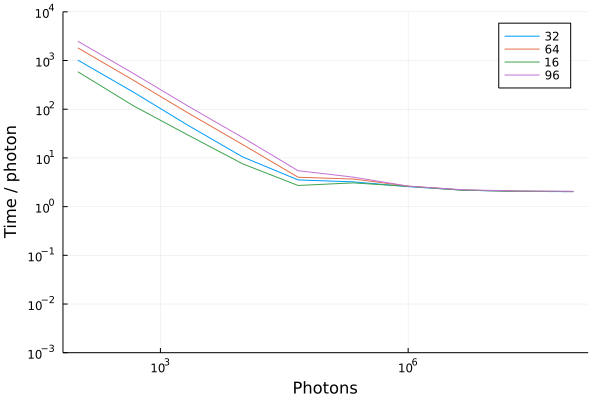

In [15]:
plt

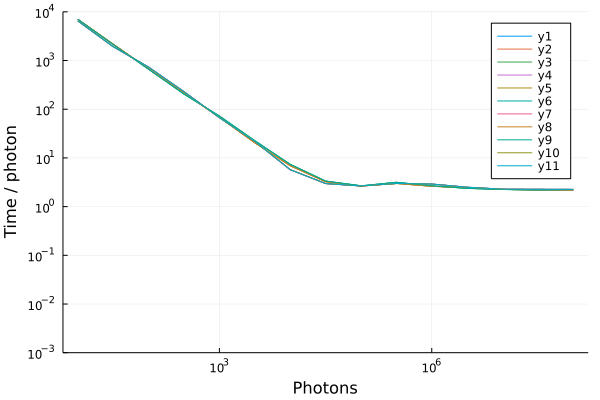

In [34]:
plot!(med_time_per_ph, yscale=:log10, ylabel="Time / photon", xlabel="Photons", ylims=(0.001, 1E4), xscale=:log10)

In [17]:
@btime CUDA.@sync @cuda threads=threads blocks=blocks shmem=sizeof(Int32) $simple_stack(
    $positions, $directions, $wavelengths, $dist_travelled, $stack_idx, $n_ph_sim, $stack_len, Int32(0), Val(source), Val(target))


  2.920 s (87 allocations: 5.17 KiB)


CUDA.HostKernel{typeof(simple_stack), Tuple{CuDeviceVector{SVector{3, Float32}, 1}, CuDeviceVector{SVector{3, Float32}, 1}, CuDeviceVector{Float32, 1}, CuDeviceVector{Float32, 1}, CuDeviceVector{Int32, 1}, CuDeviceVector{Int64, 1}, Int32, Int32, Val{PhotonSource{Float32, Monochromatic{Float32}, Isotropic{Float32}}(Float32[0.0, 0.0, 0.0], 0.0f0, 1000000000, Monochromatic{Float32}(450.0f0), Isotropic{Float32}())}, Val{PhotonTarget{Float32}(Float32[0.0, 0.0, 100.0], 0.21f0)}}}(simple_stack, CuContext(0x0000000004eac840, instance 4f296851834450ea), CuModule(Ptr{Nothing} @0x0000000003ec4310, CuContext(0x0000000004eac840, instance 4f296851834450ea)), CuFunction(Ptr{Nothing} @0x000000000d085ee0, CuModule(Ptr{Nothing} @0x0000000003ec4310, CuContext(0x0000000004eac840, instance 4f296851834450ea))), CUDA.KernelState(Ptr{Nothing} @0x00007fba8fc00000))

1:204177 to 1:204177
1000001:1203727 to 204178:407904
2000001:2203923 to 407905:611827
3000001:3203577 to 611828:815404
4000001:4204353 to 815405:1019757
5000001:5203622 to 1019758:1223379
6000001:6203071 to 1223380:1426450
7000001:7204136 to 1426451:1630586
8000001:8203539 to 1630587:1834125
9000001:9204133 to 1834126:2038258
10000001:10203766 to 2038259:2242024
11000001:11204296 to 2242025:2446320
12000001:12203778 to 2446321:2650098
13000001:13204376 to 2650099:2854474
14000001:14204399 to 2854475:3058873
15000001:15203633 to 3058874:3262506
1:204177 to 1:204177
1000001:1203727 to 204178:407904
2000001:2203923 to 407905:611827
3000001:3203577 to 611828:815404
4000001:4204353 to 815405:1019757
5000001:5203622 to 1019758:1223379
6000001:6203071 to 1223380:1426450
7000001:7204136 to 1426451:1630586
8000001:8203539 to 1630587:1834125
9000001:9204133 to 1834126:2038258
10000001:10203766 to 2038259:2242024
11000001:11204296 to 2242025:2446320
12000001:12203778 to 2446321:2650098
13000001:

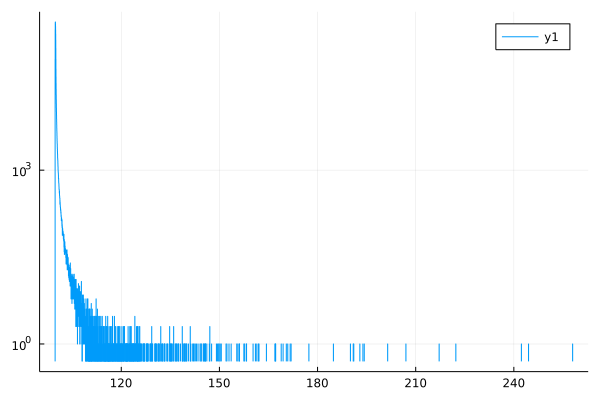

In [13]:
function process_output(output::AbstractVector{T}, stack_pointers::AbstractVector{T}) where T
    out_size = size(output, 1)
    stack_len = Int64(out_size / size(stack_pointers, 1))

    stack_starts = collect(1:stack_len:out_size)
    out_sum = sum(stack_pointers .% stack_len)
    coalesced = Vector{T}(undef, out_sum)
    ix = 1
    for i in 1:size(stack_pointers, 1)
        sp = stack_pointers[i]
        this_len = (sp - stack_starts[i]) + 1
        coalesced[ix:ix+this_len-1] = output[stack_starts[i]:sp]
        #println("$(stack_starts[i]:sp) to $(ix:ix+this_len-1)")
        ix += this_len
       
    end
    coalesced
end

distt = process_output(Vector(dist_travelled), Vector(stack_idx))
histogram(distt, yscale=:log10)
    

In [14]:
suite = BenchmarkGroup()

nphs = trunc.(Int, 10 .^ (range(1, 7.5, length=20)))
#nphs = [10]

for nph in nphs
    suite[nph] = make_bench_cuda_step_photons!(nph)
end

results = run(suite, verbose=true)
med_time_per_ph = Dict(key => val.time / key for (key, val) in median(results))
print(med_time_per_ph)
plot(med_time_per_ph, yscale=:log10, ylabel="Time / photon", xlabel="Photons", ylims=(0.1, 1E3), xscale=:log10)

UndefVarError: UndefVarError: initialize_photons not defined

In [17]:
propagate_sources([source])

Remainder: 100
Initiliazing starting 1 for 100 photons
Queuing kernel for 100


8×100 Matrix{Float32}:
  -9.7967       2.26205       -0.086697   …   34.1936        -9.09486
   6.87628     -3.77018       -2.69577       -25.0345         2.33728
 254.018      138.398        121.493         186.692        351.95
  -0.0323227    0.00569849     0.0486545      -0.000360459    0.0122193
  -0.0197152   -0.000963214   -0.0816296      -0.0019473      0.0051792
   0.999283     0.999983       0.995474   …    0.999998       0.999912
 255.443      140.166        121.728         200.863        352.649
   0.0          0.0            1.0             0.0            1.0

In [18]:

"""   


sca_len = 10.0f0

photons = initialize_photons(N, Float32, (T) -> [0.0f0, 0.0f0, 0.0f0], initialize_direction_isotropic, (T) -> 1 / 20.0f0)
intersected = CuArray(zeros(Bool, N))

steps = UInt16(10)
seed = UInt32(1)

pos = CuArray(photons[1:3, :])
dir = CuArray(photons[4:6, :])
dist_travelled = CuArray(photons[7, :])
sca_coeffs = CuArray(photons[8, :])

kernel = @cuda launch = false cuda_step_photons!(
    pos,
    dir,
    dist_travelled,
    sca_coeffs,
    intersected,
    Val(target),
    Val(steps),
    seed)
config = launch_configuration(kernel.fun, shmem=calc_shmem)
threads = min(N, config.threads)
blocks = cld(N, threads)
println("N: $N, threads: $threads, blocks: $blocks")
shmem = calc_shmem(threads)
bench = @benchmarkable CUDA.@sync $kernel(
    $pos, $dir, $dist_travelled, $sca_coeffs, $intersected, $(Val(target)), $(Val(steps)), $seed, threads=$threads, blocks=$blocks, shmem=$shmem)
CUDA.reclaim()
"""

UndefVarError: UndefVarError: steps not defined

In [19]:
photons[:, 1]

UndefVarError: UndefVarError: photons not defined

In [20]:
target_pos = @SVector [0.0f0, 0.0f0, 5.0f0]
target = PhotonTarget(target_pos, 1.0f0)

N = 15
positions = zeros(Float32, 3, N)
dirs = Matrix{Float32}(undef, 3, N)
for i in 1:N
    dirs[:, i] = [0f0, 0f0, 1f0] # initialize_direction_isotropic(Float32)
end

sca_len = 20f0

photon_config = PhotonConfig(target, 1 / sca_len, 1.0f0)
#pos, dir, intersected, dist_travelled = generate_inputs(N)
steps = UInt16(10)

intersected = zeros(Bool, N)
dist_travelled = zeros(Float32, N)

pos, dirs, intersected, dist_travelled = CuArray(positions), CuArray(dirs), CuArray(intersected), CuArray(dist_travelled)

UndefVarError: UndefVarError: PhotonConfig not defined

In [21]:
all_pos = propagate(pos, dirs, intersected, dist_travelled, photon_config, UInt16(10), UInt32(1))

UndefVarError: UndefVarError: pos not defined

In [22]:
plot(all_pos[2,:,:]', all_pos[3, :, :]')

UndefVarError: UndefVarError: all_pos not defined

In [23]:
struct Medium
    scattering_function::Function
    scattering_length::Function
    absorption_length::Function
end

function sca_len_part(wavelength, vol_conc_small_part, vol_conc_large_part)
    """
    Make a function that calculates the scattering length based on particle concentrations.
    Copied from clsim.

    Parameters:
        vol_conc_small_part: Volumetric concentration of small particles (ppm)
        vol_conc_large_part: Volumetric concentration of large particles (ppm)

    """
    ref_wlen = 550  # nm
    x = ref_wlen / wavelength

    sca_coeff = (
        0.0017 * x^4.3
        + 1.34 * vol_conc_small_part * x^1.7
        + 0.312 * vol_conc_large_part * x^0.3
    )

    return 1 / sca_coeff
end

cascadia_sca_len = wavelength -> sca_len_part(wavelength, 0.0075, 0.0075)



#16 (generic function with 1 method)

In [24]:
CUDA.clamp

clamp (generic function with 6 methods)

In [25]:
mutable struct Photon{T<:Real}
    position::SVector{3, T}
    direction::SVector{3, T}
    dist_travelled::T
    wavelength::T
    #scattering_length::T
    #group_velocity::T
    #phase_velocity::T
    steps::Int
    intersected::Bool
end
Adapt.@adapt_structure Photon

function rotate_to_new_direc(old_dir::SVector{3, T}, new_dir::SVector{3, T}, operand::SVector{3, T}) where T
    
    if old_dir == new_dir
        return operand
    end
    
    axis = cross(old_dir, new_dir)
    axis /= norm(axis)

    theta = acos(dot(old_dir, new_dir))

    # Rodrigues' rotation formula

    v_rot = (
        operand * cos(theta)
        + cross(axis, operand) * sin(theta)
        + axis
        * dot(axis, operand)
        * (1 - cos(theta))
    )
end

struct IntersectionResult{T<:Real}
    intersected::Bool
    position::Union{Nothing, AbstractArray{T, 1}}
end

struct PhotonTarget{T<:Real}
    position::AbstractArray{T, 1}
    radius::T
end

function photon_sphere_intersection(photon::Photon, photon_target::PhotonTarget{T}, step_size::T) where T
    """
    Calculate intersection.

    Given a photon origin, a photon direction, a step size, a target location and a target radius,
    calculate whether the photon intersects the target and the intrsection point.
    """
    p_normed = photon.direction   # assume normed
    photon_pos = photon.position
    target_pos = target.position
    target_r = target.radius

    a = dot(p_normed, (photon_pos - target_pos))
    b = a^2 - (norm(photon_pos - target_pos) ^ 2 - target_r^2)
    if b < 0
        return IntersectionResult{T}(false, nothing)
    end
    # Distance of of the intersection point along the line
    d = -a - sqrt(b)

    isected = (b >= 0) & (d > 0) & (d < step_size)

    if isected
        return IntersectionResult(true, photon_pos + d * p_normed)

    else
        return IntersectionResult{T}(false, nothing)
    end
end


   
function scattering_func(g::T) where T
    """Henyey-Greenstein scattering in one plane."""
    eta = T(rand(Uniform{T}(T(0), T(1))))
    costheta = (1 / (2 * g) * (1 + g^2 - ((1 - g^2) / (1 + g * (2 * eta - 1))) ^ 2))

    acos(clamp(costheta, T(-1), T(1)))
end

function move_photon!(photon::Photon{T}, target::PhotonTarget{T}, step_size::T) where T

    isec = photon_sphere_intersection(photon, target, step_size)

    if isec.intersected
        photon.dist_travelled += norm(isec.position - photon.position)
        photon.position = isec.position
        photon.intersected = true
        return nothing
    end
            

    photon.position = photon.position + photon.direction * step_size
    photon.dist_travelled += step_size

    sca_theta = scattering_func(T(0.97))
    sca_phi = T(rand(Uniform{T}(T(0), T(2*pi))))
    dir_cart = sph_to_cart(sca_theta, sca_phi)
    e_z = @SVector[0, 0, T(1)]
    photon.direction = rotate_to_new_direc(e_z, photon.direction, dir_cart)
    nothing
end

function move_photons!(photons::AbstractVector{Photon{T}}, target::PhotonTarget{T}, step_size::T) where T
    @. move_photon!(photon, target, step_size)
    """
    for photon in photons
        move_photon!(photon, target, step_size)
    end
    """
    nothing
end

function photon_step!(photon::Photon{T}, target::PhotonTarget{T}, sca_len::T) where T
    step_size = T(rand(Exponential(sca_len)))
    move_photon!(photon, target, step_size)
    nothing
end

function do_steps(photon::Photon{T}, target::PhotonTarget{T}, sca_len::T, steps::Int) where T
    positions = SVector{3, T}[]
    for _ in 1:steps
        photon_step!(photon, target, sca_len)
        push!(positions, photon.position)
    end
    positions
end

function sph_to_cart(theta::T, phi::T) where T
    x::T = cos(phi) * sin(theta)
    y::T = sin(phi) * sin(theta)
    z::T = cos(theta)
    @SVector[x, y, z]
    #CuArray([x, y, z])
end

function initialize_direction_isotropic(T::Type)
    theta = T(rand(Uniform(-1., 1)))
    phi = T(rand(Uniform(0, 2*pi)))
    sph_to_cart(theta, phi)
end

function make_photons(num::Int, T::Type)
    pos = @SVector[T(0.), 0, 0]
    #pos = CuArray(zeros(T, 3))
    dist_travelled = T(0)
    wavelength = T(200)
    steps = 0
    intersected = false
    [Photon(pos, initialize_direction_isotropic(T), dist_travelled, wavelength, steps, intersected) for i in 1:num]

end



ErrorException: invalid redefinition of type PhotonTarget

In [26]:
photons = make_photons(Int64(1E6), Float32);

UndefVarError: UndefVarError: make_photons not defined

In [27]:
photons = make_photons(Int64(1E6), Float32)
target = PhotonTarget(@SVector[1f0, 0, 0], 0.21f0)
@benchmark positions = do_steps.(photons, [target], 20f0, 10)


UndefVarError: UndefVarError: make_photons not defined

In [28]:
@profile photon_step!.(photons, [target], 20f0)

UndefVarError: UndefVarError: photon_step! not defined

In [29]:
Profile.print()

Overhead ╎ [+additional indent] Count File:Line; Function
  ╎29 @Base/client.jl:495; _start()
  ╎ 29 @Base/client.jl:292; exec_options(opts::Base.JLOptions)
  ╎  29 @Base/Base.jl:418; include(mod::Module, _path::String)
  ╎   29 @Base/loading.jl:1253; _include(mapexpr::Function, mod...
  ╎    29 @Base/loading.jl:1196; include_string(mapexpr::typeof...
  ╎     29 @Base/boot.jl:373; eval
  ╎    ╎ 29 ...otebook/notebook.jl:32; top-level scope
  ╎    ╎  29 ...c/serve_notebook.jl:75; (::VSCodeServer.var"#serve_not...
  ╎    ╎   29 .../serve_notebook.jl:136; serve_notebook(pipename::Str...
  ╎    ╎    29 @JSONRPC/src/typed.jl:67; dispatch_msg(x::VSCodeServer...
  ╎    ╎     29 ...serve_notebook.jl:13; notebook_runcell_request(con...
  ╎    ╎    ╎ 29 ...erver/src/repl.jl:184; withpath(f::VSCodeServer.va...
  ╎    ╎    ╎  29 ...serve_notebook.jl:19; (::VSCodeServer.var"#164#16...
  ╎    ╎    ╎   29 @Base/essentials.jl:714; invokelatest
  ╎    ╎    ╎    29 ...e/essentials.jl:716; #invokelatest#

  ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +23 2  ...einfer.jl:823; typeinf_edge
  ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +24 2  ...einfer.jl:209; typeinf(interp:...
  ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +25 2  ...einfer.jl:226; _typeinf(interp...
  ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +26 2  ...tation.jl:2014; typeinf_nocycle...
  ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +27 2  ...tation.jl:1918; typeinf_local(i...
  ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +28 2  ...tation.jl:1534; abstract_eval_s...
  ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +29 2  ...tation.jl:1382; abstract_call(i...
  ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +30 2  ...tation.jl:1397; abstract_call(i...
  ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +31 2  ...tation.jl:1342; abstract_call_k...
  ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +32 2  ...tation.jl:105; abstract_call_g...
  ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +33 2  ...tation.jl:504; abstract_call_m...
  ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +34 2  ...einfer.jl:823; typeinf_edge
  ╎    ╎  

  ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +30 4  ...einfer.jl:209; typeinf(interp:...
  ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +31 4  ...einfer.jl:226; _typeinf(interp...
  ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +32 4  ...tation.jl:2014; typeinf_nocycle...
  ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +33 4  ...tation.jl:1918; typeinf_local(i...
  ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +34 4  ...tation.jl:1534; abstract_eval_s...
  ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +35 4  ...tation.jl:1382; abstract_call(i...
  ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +36 4  ...tation.jl:1397; abstract_call(i...
  ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +37 4  ...tation.jl:1342; abstract_call_k...
  ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +38 4  ...tation.jl:113; abstract_call_g...
  ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +39 1  ...tation.jl:528; abstract_call_m...
  ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +40 1  ...tation.jl:581; maybe_get_const...
 1╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +41 1  ...tation.jl:619; const_prop_argu..

In [30]:
@benchmark $photon_step!.($photons, [$target], 20f0)

UndefVarError: UndefVarError: photon_step! not defined

In [31]:
500E6 / 1E6

500.0

In [32]:
using Plots
x = cat([ cat(positions[i]..., dims=2)[1, :] for i in 1:1000]..., dims=2)
y = cat([ cat(positions[i]..., dims=2)[2, :] for i in 1:1000]..., dims=2)
plot(x, y, legend=false)

BoundsError: BoundsError: attempt to access 3×15 Matrix{Float32} at index [46]

In [33]:
@btime $move_photon!.($photons, [1.])

UndefVarError: UndefVarError: move_photon! not defined

In [34]:
@btime $move_photons!($photons, 1.)

UndefVarError: UndefVarError: move_photons! not defined

In [35]:
215E6 / 1E6

215.0

In [36]:
@btime move_photon(a, 1.)

UndefVarError: UndefVarError: move_photon not defined

In [37]:
function test()
    a::Float32 = 1.2
    b::Float64 = 1.2

    print(typeof(a*b))
end


test (generic function with 1 method)

In [38]:
test()

Float64